In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
os.listdir('data')

['savingacct_txn.csv',
 'creditcard_txn.csv',
 '.DS_Store',
 'cust_past1year_snapshot.xlsx',
 'cust.csv',
 'currentacct_txn.csv',
 'cust_dna.csv',
 'model',
 'cust_prev.csv']

In [3]:
df_cur = pd.read_csv('data/cust.csv')
df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
df_prev = pd.read_csv('data/cust_prev.csv')

df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

df_comb['is_affluent_prev'] = (df_comb['BE_SEGMENT_prev'] <= 2).astype(int)
df_comb['is_affluent_cur'] = (df_comb['BE_SEGMENT_cur'] <= 2).astype(int)
df_comb = df_comb[df_comb['is_affluent_prev'] == 0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_comb.groupby(['is_affluent_cur']).count()[['id']]

,id
is_affluent_cur,
0,5740
1,257


In [5]:
df_reg = df_comb[['id', 'is_affluent_cur']]
df_reg = df_reg.drop_duplicates('id')

train = pd.read_csv('data/model/train.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
val = pd.read_csv('data/model/validate.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
test = pd.read_csv('data/model/test.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
val_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in val['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

In [6]:
del df_comb

# Transactions 

In [7]:
fname = 'data/savingacct_txn.csv'
col_date = 'D_TRANSACTION_DATE'
col_amt = 'D_TRAN_AMOUNT'
col_mult = 'D_TRAN_TYPE'

In [8]:
df_saving = pd.read_csv(fname)

tmp = set(df_reg['id'])
df_saving = df_saving[[cid in tmp for cid in df_saving['id']]]

df_saving['day'] = pd.to_datetime(df_saving[col_date])

df_saving['transact_d'] = df_saving['transact_c'] = df_saving[col_amt]
df_saving.loc[df_saving[col_mult] == 'C', 'transact_d'] = 0
df_saving.loc[df_saving[col_mult] == 'D', 'transact_c'] = 0
df_saving = df_saving[['id', 'day', 'transact_c', 'transact_d']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
placeholders = []
for cid in df_reg['id']:
    tmp = pd.date_range(start='1/1/2021', end='31/12/2021')
    tmp = pd.DataFrame({'day': tmp, 'transact_c': 0, 'transact_d': 0})
    tmp.insert(0, 'id', cid)
    placeholders.append(tmp)
df_saving = df_saving.append(pd.concat(placeholders))

df_saving['day'] = (pd.to_datetime(df_saving['day']) \
                       .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000

df_saving = df_saving.sort_values(['id', 'day'])
df_saving = df_saving.groupby(['id', 'day']).sum().reset_index(drop=False)

### Feature extraction

In [59]:
rolling_window = 14

dict_rolled = {}
for cid in tqdm(df_reg['id']):
    df = df_saving[df_saving['id'] == cid][['transact_c', 'transact_d']]
    df = df.rolling(window=rolling_window).apply(lambda x : sum(x) / rolling_window)
    df = df.dropna()
    dict_rolled[cid] = df

  0%|          | 0/5994 [00:00<?, ?it/s]

(-7.24422751560335, 11.351268164163818, -7.24422751560335, 11.361655024933835)

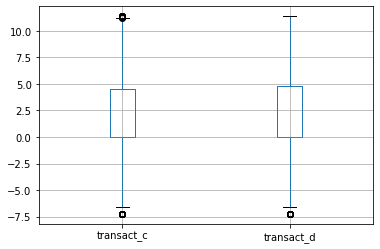

In [60]:
tmp = pd.concat(list(dict_rolled.values()))
tmp = np.log(tmp.replace({0: 1}))
tmp.boxplot()
tmp['transact_c'].min(), tmp['transact_c'].max(), tmp['transact_d'].min(), tmp['transact_d'].max()

In [61]:
bin_size = 0.4
bin_min, bin_max = -7.5, 11
bins = [bin_min + i * bin_size for i in range(int((bin_max - bin_min) / bin_size) + 1)]

def transacts_to_bins(transacts):
    transacts = np.log(transacts.replace({0: 1}))
    feat = np.zeros((len(bins)))
    tmp = np.digitize(transacts, bins) - 1
    tmp = pd.DataFrame(tmp).reset_index(drop=False).groupby(0).count()['index']
    feat[tmp.index] = tmp
    return feat

X = np.zeros((len(df_reg), len(bins) * 2))
for i, cid in tqdm(enumerate(df_reg['id'])):
    feat_c = transacts_to_bins(dict_rolled[cid]['transact_c'])
    feat_d = transacts_to_bins(dict_rolled[cid]['transact_d'])
    X[i, :] = np.concatenate([feat_c, feat_d])

0it [00:00, ?it/s]

In [62]:
X.sum(axis=0)

array([1.039400e+04, 0.000000e+00, 7.509000e+03, 3.406000e+03,
       5.241000e+03, 6.965000e+03, 5.591000e+03, 5.304000e+03,
       5.216000e+03, 4.122000e+03, 3.405000e+03, 3.605000e+03,
       4.149000e+03, 3.925000e+03, 3.089000e+03, 2.960000e+03,
       2.808000e+03, 4.114000e+03, 1.266229e+06, 3.856000e+03,
       4.215000e+03, 7.933000e+03, 5.717000e+03, 1.447200e+04,
       1.084300e+04, 2.225200e+04, 2.198800e+04, 4.178000e+04,
       3.758200e+04, 6.580000e+04, 6.179800e+04, 7.903700e+04,
       7.702700e+04, 7.907600e+04, 7.041700e+04, 5.849100e+04,
       3.648600e+04, 2.365400e+04, 1.571900e+04, 1.039600e+04,
       6.266000e+03, 3.593000e+03, 1.706000e+03, 9.920000e+02,
       5.430000e+02, 1.680000e+02, 4.900000e+01, 7.300000e+01,
       0.000000e+00, 6.800000e+01, 5.000000e+01, 5.400000e+01,
       1.120000e+02, 5.100000e+01, 6.900000e+01, 7.900000e+01,
       1.070000e+02, 1.310000e+02, 9.800000e+01, 6.520000e+02,
       5.990000e+02, 5.240000e+02, 3.400000e+02, 7.8900

### Modelling (SVM)

In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix, roc_curve, 
    precision_recall_fscore_support, plot_roc_curve, roc_auc_score
)

y = df_reg['is_affluent_cur']

X_train = X[train_idxs, :]
y_train = np.array(y)[train_idxs]
X_val = X[val_idxs, :]
y_val = np.array(y)[val_idxs]
X_test = X[test_idxs, :]
y_test = np.array(y)[test_idxs]

In [64]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [65]:
pred_probs = svm.predict_proba(X_val)

In [73]:
pred = (pred_probs[:, 0] < 0.955).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
print(precision, recall, f1)
confusion_matrix(pred, y_val)

0.9314448836187966 0.7666666666666667 0.8337288508020215


array([[672,  21],
       [189,  18]])

0.6826290240924388

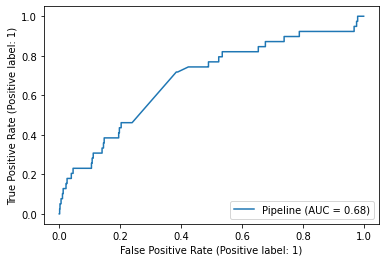

In [69]:
plot_roc_curve(svm, X_val, y_val)
roc_auc_score(y_val, pred_probs[:, 1])

```
rolling_window = 10
bin_size = 0.5
bin_min, bin_max = -7, 11.5
bins = [bin_min + i * bin_size for i in range(int((bin_max - bin_min) / bin_size) + 1)]
auc = 0.66
```

_________________

```
rolling_window = 14
bin_size = 0.4
bin_min, bin_max = -7.5, 11
auc = 0.68
```